# Visualization of cloud classes

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline  
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import seaborn as sns
import pandas as pd
import dask.array as da
import time
import pickle
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#from IPython.display import clear_output
#clear_output(wait=True)

In [2]:
import pandas as pd
import xarray as xr
import numpy as np

### List of directories 

In [3]:
griddir = '/scratch/b/b380459/icon_4_hackathon/grids/'
georgedir = '/pf/b/b380796/scratch/hackathon/george/'
maskdir = '/scratch/b/b380459/icon_4_hackathon/openocean_masks/'
nicoledir = '/scratch/b/b380490/hackathon/'

### Aiko's color dictionary

In [4]:
# https://github.com/aikovoigt/nawdex-hackathon/blob/master/dict_nawdexsims.py
# define dictionary for coloring resolutions
def colordictionary():
    # manually defined colors
    mymaroon= np.array([128,   0,   0])/255
    myred   = np.array([230,  25,  75])/255
    myorange= np.array([245, 130,  48])/255
    mymagenta=np.array([240, 50, 230 ])/255
    myolive = np.array([128, 128,   0])/255
    myteal  = np.array([  0, 128, 128])/255
    myblue  = np.array([  0, 130, 200])/255
    mynavy  = np.array([  0,   0, 128])/255

    return {'80' : mymaroon, '40' : myred, '20' : myorange, '10' : myolive, '5' : myteal, '2' : myblue}

farbe = colordictionary()

## 1a. Domain map colored by cloud class

In [4]:
# Extract the lat / lon for the associated grid.
grid = xr.open_dataset(griddir + 'icon-grid_nawdex_78w40e23n80n_R80000m.nc')

# Number of cloud classes defined.
nclasses = 8

# Convert from radians to degrees.
rad2deg = 180.0/np.pi
vlat = rad2deg*grid['vlat'].values
vlon = rad2deg*grid['vlon'].values

# Subtract one from the cell vertices as python is zero-indexed.
vertex = grid['vertex_of_cell'].values - 1

In [5]:
# Matrix A contains the number of grid cells labeled with class values 1-8.
    # For initial setup, generate with random integers 1-8.
    #A = np.random.randint(low=1,high=nclasses+1,size=(ncells))
A = np.load(georgedir + 'cloud_class_array_thres10p_v1.npy',allow_pickle='True') # shape = (7920,)

Text(0, 0.5, 'Cloud class')

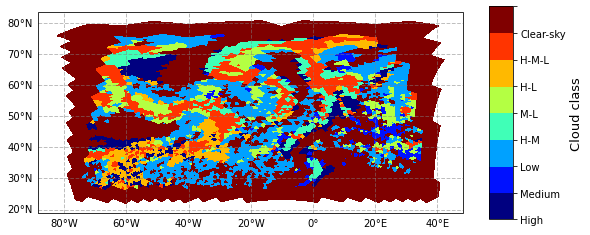

In [6]:
# Fontsize for all plots below.
fs = 13

# Create a discrete colormap.
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in np.arange(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(np.nanmin(A), int(np.nanmax(A))+1, int(np.nanmax(A))+1)
cbar_lbls = ['High','Medium','Low','H-M','M-L','H-L','H-M-L','Clear-sky']
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Plot a spatial field of the different classes
fig1a, ax = plt.subplots(1,1,figsize=(11.5,3.7),subplot_kw={'projection': ccrs.PlateCarree()})
plt.tripcolor(vlon, vlat, vertex.T, facecolors=A, edgecolors='none', cmap=cmap, norm=norm)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,
        linewidth=1,color='gray',alpha=0.5,linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.top_labels = False
gl.right_labels = False

ax2 = fig1a.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, 
                          boundaries=bounds, format='%1i')
cbar.set_ticklabels(cbar_lbls)
ax2.set_ylabel('Cloud class',fontsize=fs)
#plt.savefig('cloud-class-map.pdf')

## 1b. Make a video of cloud class maps

In [7]:
# Generate a video of the cloud classifications (or the cloud radiative effects) over time.
import matplotlib.animation as ani
import glob
import subprocess

## 2. Box plot of cloud class occurrences over time

In [8]:
# Now for more than one timestep, A becomes a 3D matrix. 
# You do not need to run this cell generally because A_df and Aarea_df can be read from pickles below.
    # For initial setup, fix an arbitary number of timesteps.
    #timesteps = 12
    #A = np.random.randint(nclasses+1,size=(ncells,timesteps))

    #fi = georgedir + 'cloud_class_array_thres10p_80km_alltimesteps_v2.npy'
    #A = da.from_array(fi,chunks=(500,500))

# Calculate the occurrence (0-100%) of each class over the timesteps and for three thresholds.
# Assumes that the classifications start from 1 not 0.
# A does not take area-weighting into account. Aarea does.
A_df = pd.DataFrame(columns=['Cloud class','Resolution','Occurrence_thr1','Occurrence_thr2',
                             'Occurrence_thr3','Occurrence_thr4','Occurrence_thr5'])
Aarea_df = pd.DataFrame(columns=['Cloud class','Resolution','Occurrence_thr1','Occurrence_thr2',
                                 'Occurrence_thr3','Occurrence_thr4','Occurrence_thr5'])
resolutions = ['80','40','20','10','5','2']
class_names = ['HI','MED','LO','H-M','M-L','H-L','H-M-L','Clear-sky']

In [ ]:
for res in resolutions:
    print(res)
    # Read in George's classifications for three different thresholds (5, 10, and 20%).
    fi_thres1 = xr.open_dataset(georgedir + 'cloud_class_array_thres5p_' + res + 'km_alltimesteps_v1_2020-10-14.nc')
    fi_thres2 = xr.open_dataset(georgedir + 'cloud_class_array_thres10p_' + res + 'km_alltimesteps_v3.nc')
    fi_thres3 = xr.open_dataset(georgedir + 'cloud_class_array_thres15p_' + res + 'km_alltimesteps_v1_2020-10-14.nc')
    fi_thres4 = xr.open_dataset(georgedir + 'cloud_class_array_thres20p_' + res + 'km_alltimesteps_v1_2020-10-14.nc')
    fi_thres5 = xr.open_dataset(georgedir + 'cloud_class_array_thres50p_' + res + 'km_alltimesteps_v1_2020-10-14.nc')
    
    A1 = fi_thres1['clch']  # (195 time steps, 2799 ocean grid cells)
    A2 = fi_thres2['clch'] 
    A3 = fi_thres3['clch'] 
    A4 = fi_thres4['clch']
    A5 = fi_thres5['clch']
    
    # Read in the grid and mask for area-weighting. Their dimensions must agree below.
    if res == '2':
        grid = xr.open_dataset(griddir + 'icon-grid_nawdex_78w40e23n80n_R2500m.nc')
    else:
        grid = xr.open_dataset(griddir + 'icon-grid_nawdex_78w40e23n80n_R' + res + '000m.nc')
    mask = xr.open_dataset(maskdir + 'nawdexnwp-' + res + 'km-mis-0001_openoceanmask.nc')['mask_openocean']
    mask = mask.rename({'ncells':'cell'})
    ncells = A1.sizes['ncells']
    timesteps = A1.sizes['time']
    cellarea = grid['cell_area'].where(mask == 1)
    totarea = cellarea.where(mask == 1).sum('cell').values
    
    # Now throw out the NaN values as the cloud classifications have done.
    cellarea = cellarea.values; cellarea = cellarea[~np.isnan(cellarea)]
    
    # Iterate over the timesteps to set Cloud class, resolution, occurrence, and radiative values.
    for dt in np.arange(timesteps):
        B1 = A1[{'time':dt}]
        B2 = A2[{'time':dt}]
        B3 = A3[{'time':dt}]
        B4 = A4[{'time':dt}]
        B5 = A5[{'time':dt}]
        
        for cloud_class in np.arange(nclasses):
            occ1 = B1[B1 == cloud_class+1].shape[0]/ncells*100
            occ2 = B2[B2 == cloud_class+1].shape[0]/ncells*100
            occ3 = B3[B3 == cloud_class+1].shape[0]/ncells*100
            occ4 = B4[B4 == cloud_class+1].shape[0]/ncells*100
            occ5 = B5[B5 == cloud_class+1].shape[0]/ncells*100
            A_df = A_df.append({'Cloud class' : class_names[cloud_class],'Resolution' : res, 'Occurrence_thr1' : occ1,
                               'Occurrence_thr2' : occ2, 'Occurrence_thr3' : occ3,'Occurrence_thr4' : occ4,
                               'Occurrence_thr5' : occ5},ignore_index=True)
            
            occ1 = np.nansum(cellarea[B1 == cloud_class+1])/totarea*100.
            occ2 = np.nansum(cellarea[B2 == cloud_class+1])/totarea*100.
            occ3 = np.nansum(cellarea[B3 == cloud_class+1])/totarea*100.
            occ4 = np.nansum(cellarea[B4 == cloud_class+1])/totarea*100.
            occ5 = np.nansum(cellarea[B5 == cloud_class+1])/totarea*100.
            Aarea_df = Aarea_df.append({'Cloud class' : class_names[cloud_class],'Resolution' : res, 'Occurrence_thr1' : occ1,
                                       'Occurrence_thr2' : occ2, 'Occurrence_thr3' : occ3,'Occurrence_thr4' : occ4,
                                       'Occurrence_thr5' : occ5},ignore_index=True)

In [9]:
# Save the occurrence dataframe in a pickle (or load it).
#A_df.to_pickle('cloud_class_occurrence_no_weighting.pkl')
#Aarea_df.to_pickle('cloud_class_occurrence_area_weighting.pkl')

A_df = pd.read_pickle('cloud_class_occurrence_no_weighting.pkl')
Aarea_df = pd.read_pickle('cloud_class_occurrence_area_weighting.pkl')

Text(0.5, 0, 'Cloud class')

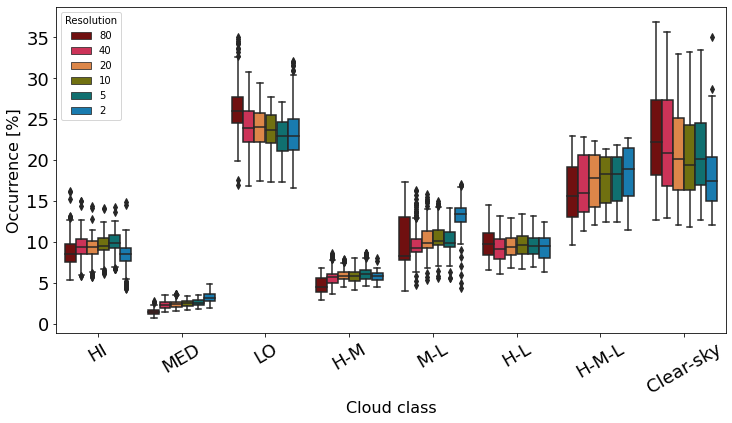

In [10]:
# Plot the spatiotemporal probability distribution of the different classes for a threshold of 10%.
fig2a = plt.figure(figsize=(12,6))
ax = sns.boxplot(x='Cloud class',y='Occurrence_thr3',hue='Resolution',data=A_df,hue_order=resolutions,palette=farbe)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,fontsize=fs+5)
ax.tick_params(axis="y", labelsize=fs+5)
ax.set_ylabel('Occurrence [%]',fontsize=fs+3)
ax.set_xlabel('Cloud class',fontsize=fs+3)
#plt.savefig('figs/class_occurrence_10p_noweighting.pdf')

Text(0.5, 0, 'Cloud class')

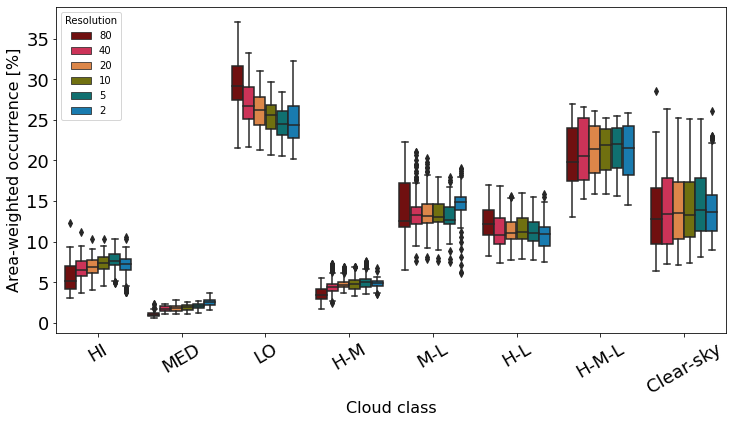

In [11]:
# Plot the spatiotemporal probability distribution of the different classes for a threshold of 10% AND area-weighting.
fig2b = plt.figure(figsize=(12,6))
#A_df.boxplot()
ax = sns.boxplot(x='Cloud class',y='Occurrence_thr1',hue='Resolution',data=Aarea_df,hue_order=resolutions,palette=farbe)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,fontsize=fs+5)
ax.tick_params(axis="y", labelsize=fs+5)
ax.set_ylabel('Area-weighted occurrence [%]',fontsize=fs+3)
ax.set_xlabel('Cloud class',fontsize=fs+3)
#plt.savefig('class_occurrence_10p_weighting.pdf')

Text(0.5, 22.199999999999996, 'Cloud class')

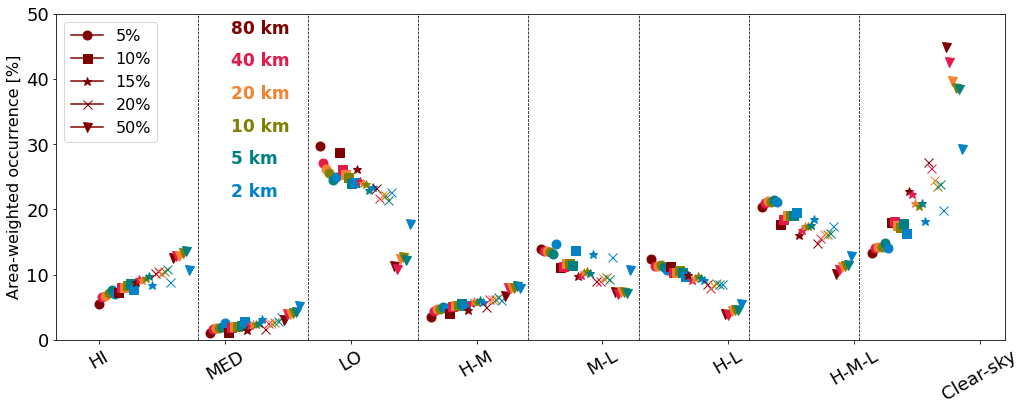

In [12]:
# Visualize the different thresholds in the same plot
fig2c = plt.figure(figsize=(17,6))
symbol = {'thr1' : 'o', 'thr2' : 's', 'thr3' : '*', 'thr4' : 'x', 'thr5' : 'v'}
thresholds = ['5%','10%','15%','20%','50%']

# Store the mean occurrences here for 5 thresholds, 6 resolutions, and 8 classes.
mean_occ = np.zeros((5,6,8))
i = 0
for t_indx, t in enumerate(['thr1','thr2','thr3','thr4','thr5']):
    for r_indx, r in enumerate(resolutions):
        for c_indx, cloud_class in enumerate(class_names):
            value = A_df[(A_df['Resolution'] == r) & (A_df['Cloud class'] == cloud_class)]['Occurrence_' + t].mean()
            mean_occ[t_indx,r_indx,c_indx] = value
            if r == '80' and c_indx == 0:
                plt.plot((c_indx+1)*10+i, value, color=farbe[r], markersize=9, marker=symbol[t],label=thresholds[t_indx])
            else:
                plt.plot((c_indx+1)*10+i, value, color=farbe[r], markersize=9, marker=symbol[t],label='_nolegend_')
            i = i+0.035
            
for i_indx,i in enumerate(np.arange(19,89,10)):
    plt.plot([i,i],[0,50],color='k',linestyle='--',linewidth=0.75)
    if i_indx < 6:
        plt.text(22,47-5*i_indx,str(resolutions[i_indx])+' km',fontsize=fs+4,weight='bold',color=farbe[resolutions[i_indx]])
    
plt.gca().set_xticks(np.linspace(10,90,8))
plt.gca().set_xticklabels(class_names,rotation=30,fontsize=fs+5)
plt.gca().tick_params(axis="y", labelsize=fs+5)
plt.gca().set_ylabel('Area-weighted occurrence [%]',fontsize=fs+3)
plt.legend(loc='upper left',fontsize=fs+3)
plt.ylim([0,50])
ax.set_xlabel('Cloud class',fontsize=fs+3)
#plt.savefig('figs/res_sens_across_thresholds.pdf')

### Is the sensitivity to resolution consistent across thresholds?

Text(0, 0.5, '$\\Delta$(class occurrence) from 80-km res')

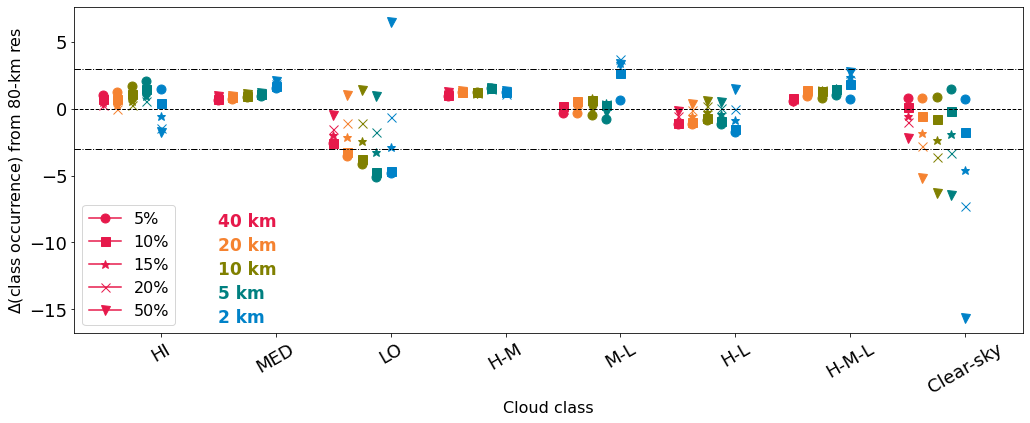

In [13]:
fig2d = plt.figure(figsize=(17,6))
for c_indx, c in enumerate(class_names):
    for r_indx, r in enumerate(resolutions[1:]):
        for t_indx, t in enumerate(['thr1','thr2','thr3','thr4','thr5']):
            if c_indx == 0 and r_indx == 0:
                lbl = thresholds[t_indx]
            else:
                lbl = '_nolegend_'
            plt.plot(c_indx*2+r_indx/4.+1,mean_occ[t_indx,r_indx+1,c_indx]-mean_occ[t_indx,0,c_indx],
                     markersize=9,marker=symbol[t],color=farbe[r],label=lbl)

for i_indx in np.arange(1,6):
    plt.text(3,-7-i_indx*1.8,str(resolutions[i_indx])+' km',fontsize=fs+4,weight='bold',color=farbe[resolutions[i_indx]])

plt.plot([0.5,17],[0,0],color='k',linestyle='--',linewidth=1)
plt.plot([0.5,17],[-3,-3],color='k',linestyle='-.',linewidth=1)
plt.plot([0.5,17],[3,3],color='k',linestyle='-.',linewidth=1)
plt.xlim([0.5,17])
plt.legend(loc='lower left',fontsize=fs+3)
plt.gca().set_xticks(np.linspace(2,16,8))
plt.gca().set_xticklabels(class_names,rotation=30,fontsize=fs+5)
plt.gca().tick_params(axis="y", labelsize=fs+5)
plt.gca().set_xlabel('Cloud class',fontsize=fs+3)
plt.gca().set_ylabel(r'$\Delta$(class occurrence) from 80-km res',fontsize=fs+3)
#fig2d.savefig('figs/res-sens-across-thresholds.pdf',bbox_inches='tight')